# Particle filtering for inference

Here, we try to put it all together to infer $\mathbf{v}$ from data.

In [1]:
import numpy as np
np.random.seed(12345)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}'
})

from tqdm import tqdm
import scipy.stats as stats
from functools import partial

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.random as jr
import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.special import logsumexp

init_key = jr.key(123)

## Make some synthetic data

(copied over from `gen_synthetic_data.ipynb`)

In [2]:
max_freq = 250  # maximum (absolute value) frequency we care about
Nlat = 3  # number of latent patterns
N = 1000  # number of samples
dt = 0.001  # sample spacing (in s)

taxis = np.arange(0, N * dt, dt)
freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))
Omega = freqs.shape[0]

In [3]:
center_freqs = [5, 25, 60]  # peak power frequencies of each latent
center_std = [.1, .5, 1.5]

all_v = []
for mu, sig in zip(center_freqs, center_std):
    right = stats.norm.pdf(freqs, loc=mu, scale=sig)
    left = stats.norm.pdf(freqs, loc=-mu, scale=sig)
    this_v = right + left
    this_v /= np.linalg.norm(this_v)
    all_v.append(this_v)

v = np.stack(all_v, axis=0)

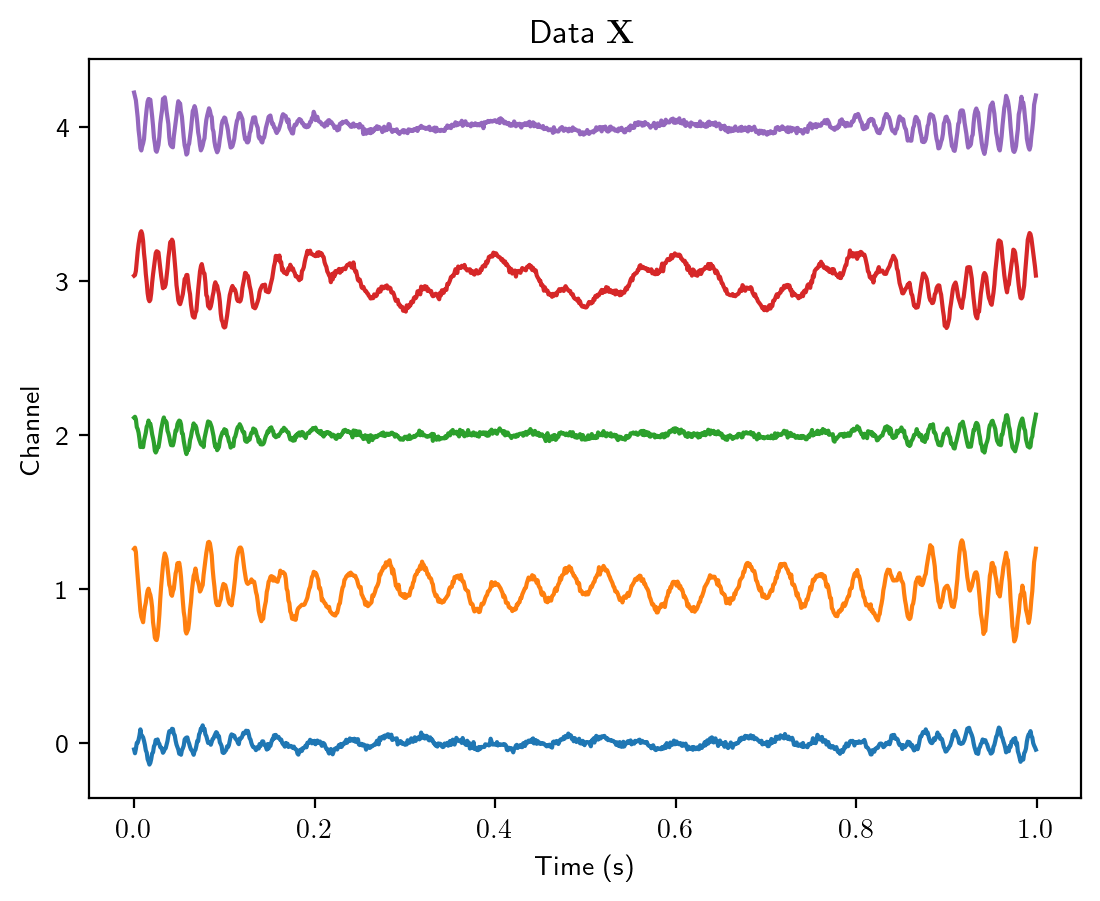

In [4]:
vv = np.fft.ifftshift(v, axes=1)
s = np.fft.ifft(vv)
s = np.real(s)  # real parts should be very near 0

# make D
Nchan = 5
D = np.random.randn(Nchan, Nlat)
D /= np.linalg.norm(D, axis=0)

# make x
eps = 1e-4
x = D @ s
x += eps * np.random.randn(*x.shape)

# plot it
scale_factor = 0.01
plt.plot(taxis, (x + scale_factor * np.arange(Nchan)[:, np.newaxis]).T);
plt.title(r"Data $\mathbf{X}$")
plt.xlabel("Time (s)")
plt.ylabel("Channel")
plt.gca().set_yticks(scale_factor * np.arange(Nchan));
plt.gca().set_yticklabels(range(Nchan));

## Define some functions for inference

(copied over from `v_sampling.ipynb`)

In [5]:
@jit
def phi(t, freqs):
    """
    Calculate phi_t as in notes. 
    Assumes \omega = 0 is at index 0!
    """
    phase = jnp.exp(1j * 2 * jnp.pi * freqs * t) 
    mask = jnp.abs(freqs) > 0
    phase *= mask
    phase /= jnp.sqrt(freqs.shape[0] - 1)
    return phase

In [6]:
@partial(jit, static_argnums=(3, 4))
def calc_vhat(vprev, bt, t, Omega, dt):
    """
    vprev = v_{t-1}
    bt    = \hat{m}_t/f_t
    t     = time
    Omega = number of frequencies
    """
    freqs = jnp.fft.fftfreq(Omega, dt)
    phit = phi(t, freqs)
    alpha = jnp.dot(vprev, phit)
    oo = Omega/np.sqrt(Omega - 1)
    lam = -jnp.conj(alpha) + oo * bt * jnp.sqrt((1 - jnp.abs(alpha)**2)/(1 - (oo * bt)**2))
    
    vv = (vprev + jnp.conj(lam * phit))/jnp.sqrt(1 + jnp.abs(lam)**2 + 2 * jnp.real(lam * alpha))
    
    return vv

In [7]:
@jit
def vMF_real2cplx(v):
    """
    Transform a N-vector draw from a vMF into v with 
    v^*{-omega} = v_{omega} (i.e., spectrum of a real signal).
    Assumes frequency 0 is also index 0!!!
    """
    vv = jnp.empty(v.shape, dtype='complex64')
    N = v.shape[0]
    mid = (N + 1)//2

    vv = vv.at[:mid].set(v[:mid])
    
    if N % 2 == 0:
        vv = vv.at[:mid].add(1j * v[mid:])
        vv = vv.at[-1:mid:-1].set(jnp.conj(vv[1:mid]))
        vv = vv.at[mid].set(jnp.conj(vv[0]))
        # vv[:mid] = v[:mid]
        # vv[:mid] += 1j * v[mid:]
        # vv[-1:mid:-1] = jnp.conj(vv[1:mid])
        # vv[mid] = jnp.conj(vv[0])
    else:
        vv = vv.at[1:mid].add(1j * v[mid:])
        vv = vv.at[-1:(mid - 1):-1].set(jnp.conj(vv[1:mid]))
        # vv[:mid] = v[:mid]
        # vv[1:mid] += 1j * v[mid:]
        # vv[-1:(mid - 1):-1] = jnp.conj(vv[1:mid])
        
    return vv/jnp.sqrt(2)

In [8]:
@jit
def vMF_cplx2real(v):
    """
    Transform a N-vector complex spectrum v with 
    v^*{-omega} = v_{omega} (i.e., spectrum of a real signal)
    to a real vector with real parts up front and imaginary parts in back.
    Assumes frequency 0 is also index 0!!!
    """
    vv = jnp.empty(v.shape, dtype=jnp.float32)
    N = v.shape[0]
    mid = (N + 1)//2

    vv = vv.at[:mid].set(jnp.real(v[:mid]))
    
    if N % 2 == 0:
        vv = vv.at[mid:].set(jnp.imag(v[:mid]))
        # vv[:mid] = jnp.real(v[:mid])
        # vv[mid:] = jnp.imag(v[:mid])
    else:
        vv = vv.at[mid:].set(jnp.imag(v[1:mid]))
        # vv[:mid] = jnp.real(v[:mid])
        # vv[mid:] = jnp.imag(v[1:mid])
    return vv * jnp.sqrt(2)

## Set up inference

Calculate some quantities that we'll need later.

In the notes, we want to solve $\min \lVert \mathbf{X} - \mathbf{DM}\rVert_F$ for $\mathbf{M}$:

In [9]:
D.shape, x.shape

((5, 3), (5, 1000))

In [10]:
M = np.linalg.lstsq(D, x)[0]
M.shape

(3, 1000)

In the data above, we have assumed $f_{jt} = 1$, so we won't worry about that.

## Do particle filtering

The goal is not to make it fast, just to test for whether we can recover $\mathbf{v}$.

We want to calculate weights. Initially:
$$
\log \tilde{w}_j = \log \mu(\mathbf{V}_j) + \log g(\mathbf{x}_0|\mathbf{V}_j) - \log q(\mathbf{V}_j|\mathbf{x}_0)
$$
where the terms are the prior, emission, and proposal distribution, respectively, and $\mathbf{V}_j$ is the $j$th particle sample of $\mathbf{v}$ at $t=0$.

In [39]:
def get_vmf_dist(vprev, kappa, calc_vhat, M):
    """
    Calculate the proposal distribution and return a sampleable 
    distribution object. 
    vprev is the *complex* representation of v
    vhat is a function that operates 
    """
    @jit
    def mu_from_v(v, b):
        vhat = calc_vhat(v, b)
        mu = vMF_cplx2real(vhat) 
        mu /= jnp.linalg.norm(mu)
        return mu

    mu = vmap(vmap(mu_from_v, in_axes=(0, 0)), in_axes=(0, None))(vprev, M)

    return tfd.VonMisesFisher(mu, kappa)

@jit
def get_v_samples(vmf, key):
    vmf_s = vmf.sample((), key)
    v_s = vmap(vmap(vMF_real2cplx))(vmf_s)

    return vmf_s, v_s

@jit
def get_data_pred(v_s, D, t):
    st = jnp.fft.ifft(v_s)
    st = jnp.real(st)
    xbar = (D @ st)[:, :, t]
    return xbar

@jit
def resample(logw, key):
    """
    Given a set of logged weights, return a set of indices corresponding to particles 
    from which the resampled weights are drawn. That is, if X are the samples, then
    X[resample(logw)] are the new particles, each with weight 1/len(logw).
    This implements Systematic Resampling as detailed in the Doucet review.
    """
    K = len(logw)

    cdf = jnp.cumsum(jnp.exp(logw))
    U = (jr.uniform(key) + jnp.arange(K))/K

    return jnp.digitize(U, cdf)


def resample_if_needed(logw, thresh, key):
    log_ESS = -logsumexp(2 * logw)

    if log_ESS < jnp.log(K) + jnp.log(thresh):
        do_resample = True
    else:
        do_resample = False

    if do_resample:
        inds = resample(logw, key)
    
        logw = -jnp.log(K) * jnp.ones(K)
    else:
        inds = range(len(logw))

    return inds, logw

In [70]:
K = 100  # number of particles
kappa = jnp.array(10000. * Omega)  # for transition
kappa_p = kappa / 100  # for proposal

In [71]:
# calculate initial guess for v
# assume "previous" v is white noise
vmfprev = jnp.ones(Omega)
vmfprev /= jnp.linalg.norm(vmfprev)
vprev = vMF_real2cplx(vmfprev)
vprev = vprev * (jnp.abs(freqs) > 0)  # no zero-frequency

v_s = jnp.tile(vprev, (K, Nlat, 1))
vmf_s = jnp.tile(vmfprev, (K, Nlat, 1))

In [72]:
%%time 
key, sample_key = jr.split(init_key)

for (tidx, t) in tqdm(enumerate(jnp.arange(0, 1, dt))):
    key, sample_key, resample_key = jr.split(key, 3)
    
    vprev = v_s
    vmfprev = vmf_s
    
    vhat_t = lambda x, y: calc_vhat(x, y, t, Omega, dt)
    vmf = get_vmf_dist(vprev, kappa_p, vhat_t, M[:, tidx])
    
    # sample based on vhat
    vmf_s, v_s = get_v_samples(vmf, sample_key)
    
    # get data prediction for this time
    xbar = get_data_pred(v_s, D, tidx)

    # term 1: transition
    # assume our transition is determined by mu = vprev above and kappa
    if t == 0:
        trans = tfd.VonMisesFisher(vmfprev, 0.)
    else:
        trans = tfd.VonMisesFisher(vmfprev, kappa)
    logw = trans.log_prob(vmf_s).sum(axis=-1)
    
    # term 2: emission
    # assume multivariate normal with mean xbar and std eps
    emissions = tfd.Normal(xbar, eps)
    logw += emissions.log_prob(x[:, tidx]).sum(axis=-1)
    
    # term 3: proposal
    # as above, distribution is vMF(mu, kappa)
    logw -= vmf.log_prob(vmf_s).sum(axis=-1)
    
    # normalize
    logw -= logsumexp(logw)

    # resample if needed
    inds, logw = resample_if_needed(logw, 0.8, resample_key)
    v_s = v_s[inds]
    vmf_s = vmf_s[inds]

1000it [09:55,  1.68it/s]

CPU times: user 9min 48s, sys: 18.5 s, total: 10min 7s
Wall time: 9min 55s


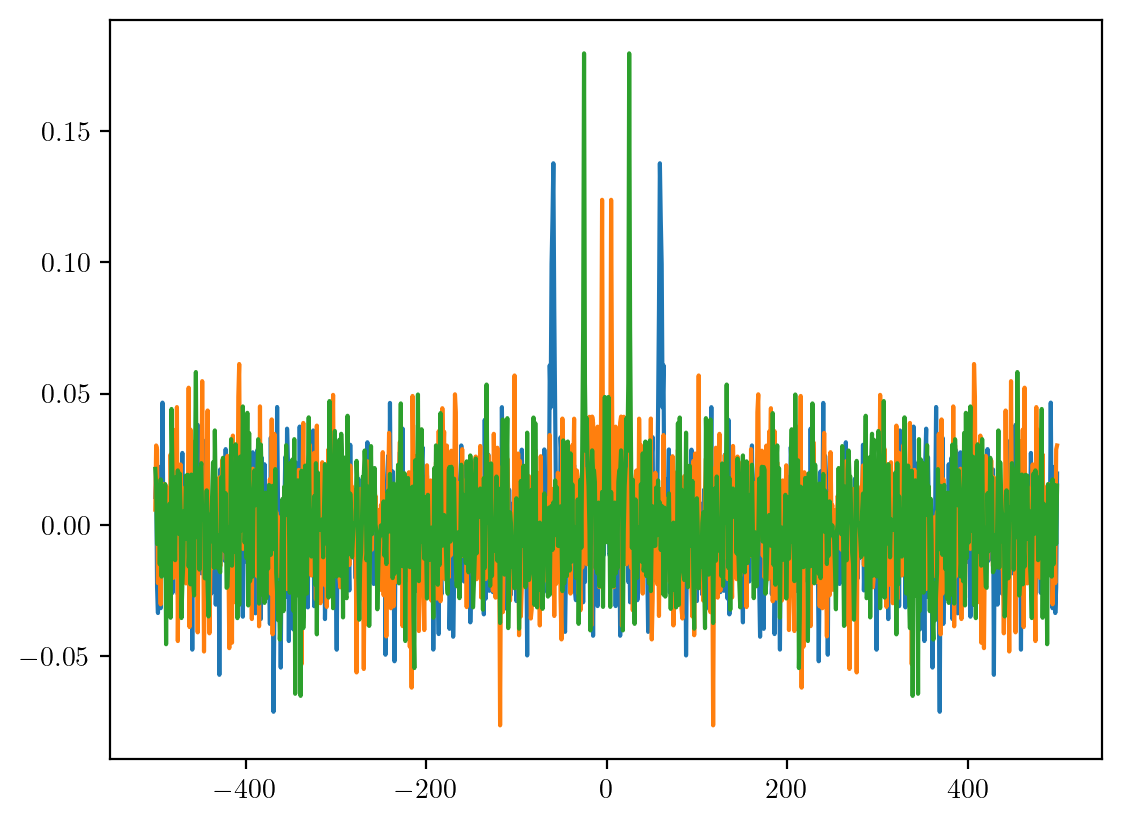

In [75]:
v_mean = np.einsum('k,klt', np.exp(logw), v_s)
plt.plot(freqs, np.real(np.fft.fftshift(v_mean)).T);

In [35]:
aa = v_s - vprev

In [36]:
aa.shape

(10, 3, 1000)

/Users/jmxp/code/vmftest/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jmxp/code/vmftest/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


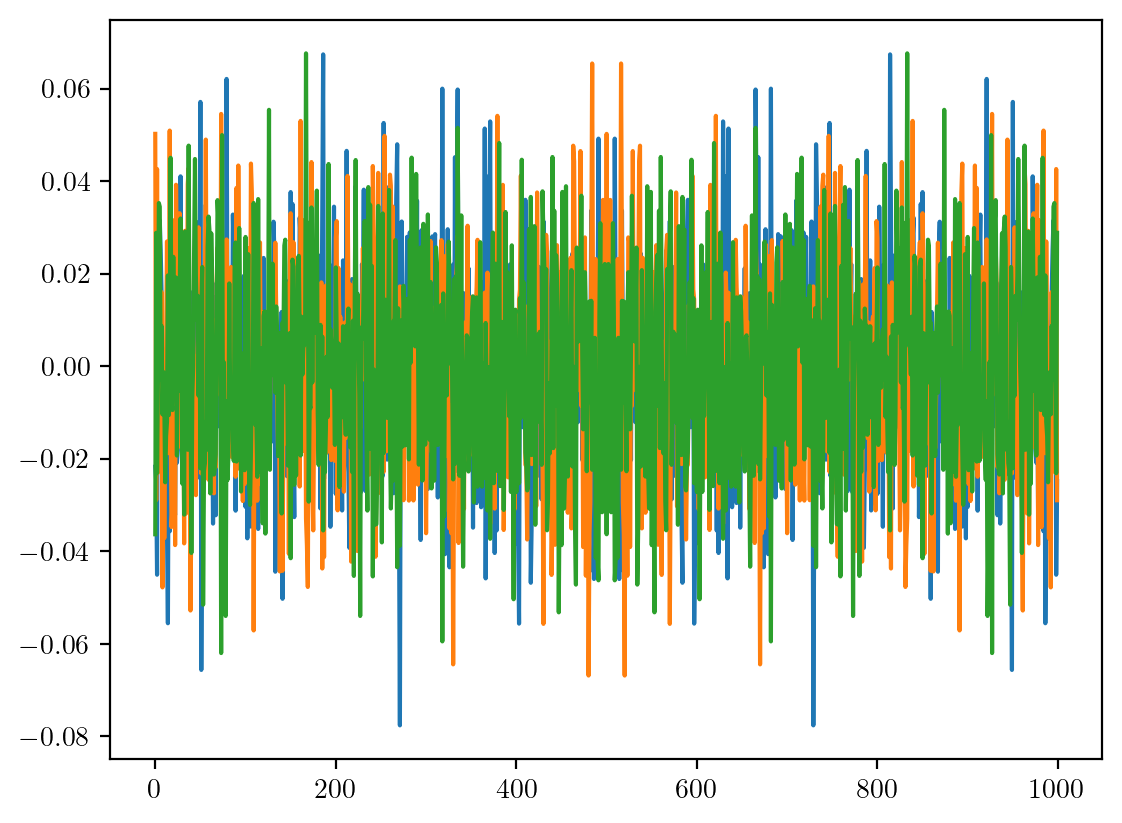

In [37]:
plt.plot(vprev[0].T)

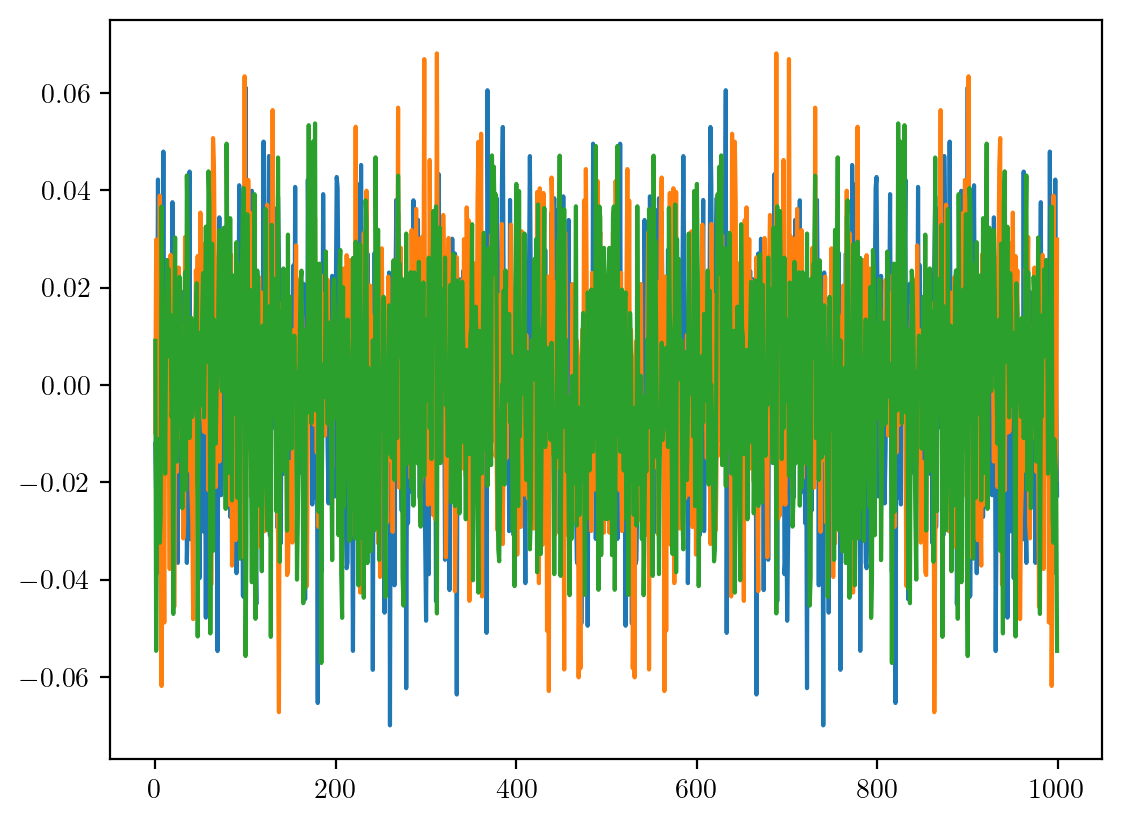

In [23]:
plt.plot(v_s[0].T)